# Speaker Recognition via Spectrogram Analysis

# Import libraries

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
!pip install ffmpeg

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [73]:
import os
DATASET_ROOT = '/content/drive/MyDrive/Colab Notebooks/GBCLessons/Math 2/classifier/Data'

AUDIO_SUBFOLDER = "audio"
AUDIO_CLEANED_SUBFOLDER = "audio_no_blanks"
SPECTROGRAM_SUBFOLDER = "spectrograms"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_CLEANED_SUBFOLDER)
SPECTROGRAM_PATH = os.path.join(DATASET_ROOT, SPECTROGRAM_SUBFOLDER)

EXAMPLE_AUDIO = DATASET_AUDIO_PATH + '/Dan/chunk1.wav'

# Example Spectrogram

Here's an example of one of the group members, Dan, speaking:

In [74]:
import IPython
IPython.display.Audio(EXAMPLE_AUDIO)

We've broken a talk of about 5-7 minutes into 1-second chunks for easier processing. Let's visualize this speech:

In [75]:
import librosa
import librosa.display
samples, sample_rate = librosa.load(EXAMPLE_AUDIO)

We can look at the audio as a graph of amplitude over time:

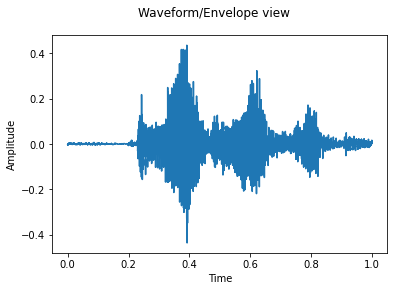

In [76]:
time = np.arange(0, 1.0, 1/sample_rate)

plt.plot(time,samples)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.suptitle('Waveform/Envelope view')
plt.show()

That graph is actually a wave, but because we take so many samples per second, it's incredibly dense! Let's look at the waveform over the course of 100 miliseconds:

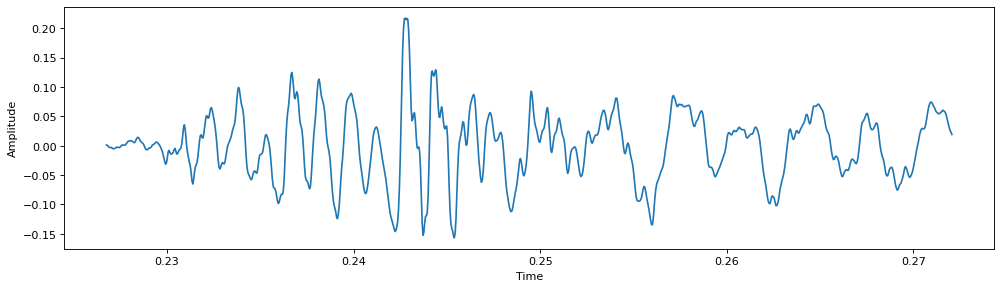

In [77]:
plt.figure(figsize=(15, 4), dpi=80)
plt.plot(time[5000:6000], samples[5000:6000])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Or as a Spectrogram:

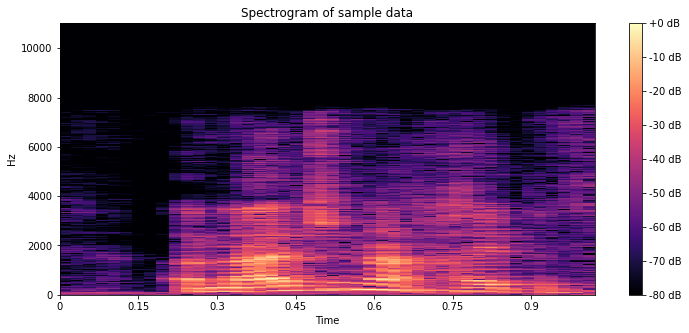

In [78]:
stft = librosa.stft(samples)
S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram of sample data')
fig.colorbar(img, ax=ax, format="%+2.f dB")

A spectrogram is a graph of frequncy (measured in Hz) over time, where the color of a node is its amplitude. Notice how we can clearly see pieces of the sound, like the start of the word "imagine" at ~0.22 seconds.

The phonemes being said appear at approximately:

phoneme | time
------- | ----
im      | 0.22
ag      | 0.37
ine     | 0.45
a       | 0.58
hyp     | 0.75
o       | 0.9

A lot of the frequency in the >8k Hz is not used, so let's look at spectrograms on a logarithmic scale using a melspectrogram:

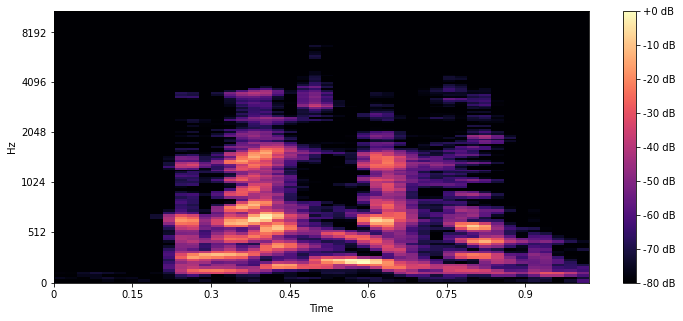

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
mel_spec = librosa.feature.melspectrogram(samples)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

# Create Spectrograms from Audio Data

## Split data into training and testing

In [80]:
import os
from os.path import isfile, join
from random import randrange

data = []
classes = os.listdir(DATASET_AUDIO_PATH)

for i in range(len(classes)):
  for f in os.listdir(DATASET_AUDIO_PATH + '/' + classes[i]):
    if f.endswith('.wav'):
      data_filepath = DATASET_AUDIO_PATH + '/' + classes[i] + '/' + f
      dataset = randrange(10) + 1
      if dataset < 9:
        dataset = 'train'
      else:
        dataset = 'valid'

      data.append([data_filepath, f, classes[i], dataset])

data = pd.DataFrame(data, columns=['filepath','filename','class','dataset'])
data

,filepath,filename,class,dataset
0,/content/drive/MyDrive/Colab Notebooks/GBCLess...,chunk105.wav,Mike,train
1,/content/drive/MyDrive/Colab Notebooks/GBCLess...,chunk111.wav,Mike,train
2,/content/drive/MyDrive/Colab Notebooks/GBCLess...,chunk129.wav,Mike,train
3,/content/drive/MyDrive/Colab Notebooks/GBCLess...,chunk115.wav,Mike,train
4,/content/drive/MyDrive/Colab Notebooks/GBCLess...,chunk101.wav,Mike,train
...,...,...,...,...
1821,/content/drive/MyDrive/Colab Notebooks/GBCLess...,chunk109.wav,Dan,train
1822,/content/drive/MyDrive/Colab Notebooks/GBCLess...,chunk337.wav,Dan,train
1823,/content/drive/MyDrive/Colab Notebooks/GBCLess...,chunk121.wav,Dan,train
1824,/content/drive/MyDrive/Colab Notebooks/GBCLess...,chunk126.wav,Dan,train


## Create Spectrograms from Audio



In [81]:
def log_mel_spec_tfm(row, dst_path):
  target = row['class']
  file_path = row['filepath']
  file_name = row['filename']
  bucket = row['dataset']

  samples, sample_rate = librosa.load(file_path)

  if librosa.get_duration(y=samples, sr=sample_rate) == 1.0:
    mel_spec_power = librosa.feature.melspectrogram(samples, sr=sample_rate, power=2.0) 
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)

    dst_path = os.path.join(dst_path, bucket)
    dst_fname = dst_path + '/' + target + '_' + (file_name[:-4] + '.png')

    plt.imsave(dst_fname, mel_spec_db)

In [82]:
for index, row in data.iterrows():
  log_mel_spec_tfm(row, SPECTROGRAM_PATH)